# **RAIN & Meta AI Academy: Building an AI with Expert Knowledge (RAG)**

**Tutor:** Victor Olufemi

### **Welcome! The Final Step in Our AI Journey.**

*   **This Lecture:** We will give our AI a custom memory. We will teach it to become an **expert** in a specific domain by giving it a library of documents to read and reference.

This is **Retrieval-Augmented Generation (RAG)**, the key to unlocking factual, trustworthy, and context-aware AI applications.

### **The Problem We're Solving**
*   LLMs have a knowledge cut-off; they don't know about recent events.
*   LLMs don't know about your private data (e.g., your company's internal documents, your personal notes).
*   LLMs can sometimes "hallucinate" or make up facts.

RAG solves this by providing the LLM with the exact information it needs, right when it needs it. **Analogy:** Instead of asking a historian a question from memory, we're giving them a specific, relevant book and asking them to answer based *only* on what's in that book.

### **Our RAG Architecture Today**
1.  **Knowledge Base:** The 3 PDF documents provided.
2.  **Embedding Model (The Indexer):** An open-source model from Hugging Face to convert text into numerical vectors.
3.  **Vector Store (The Library):** A super-fast database (FAISS) to store and search these vectors.
4.  **LLM (The Brain):** Meta's Llama 3 via Groq for the final generation step.

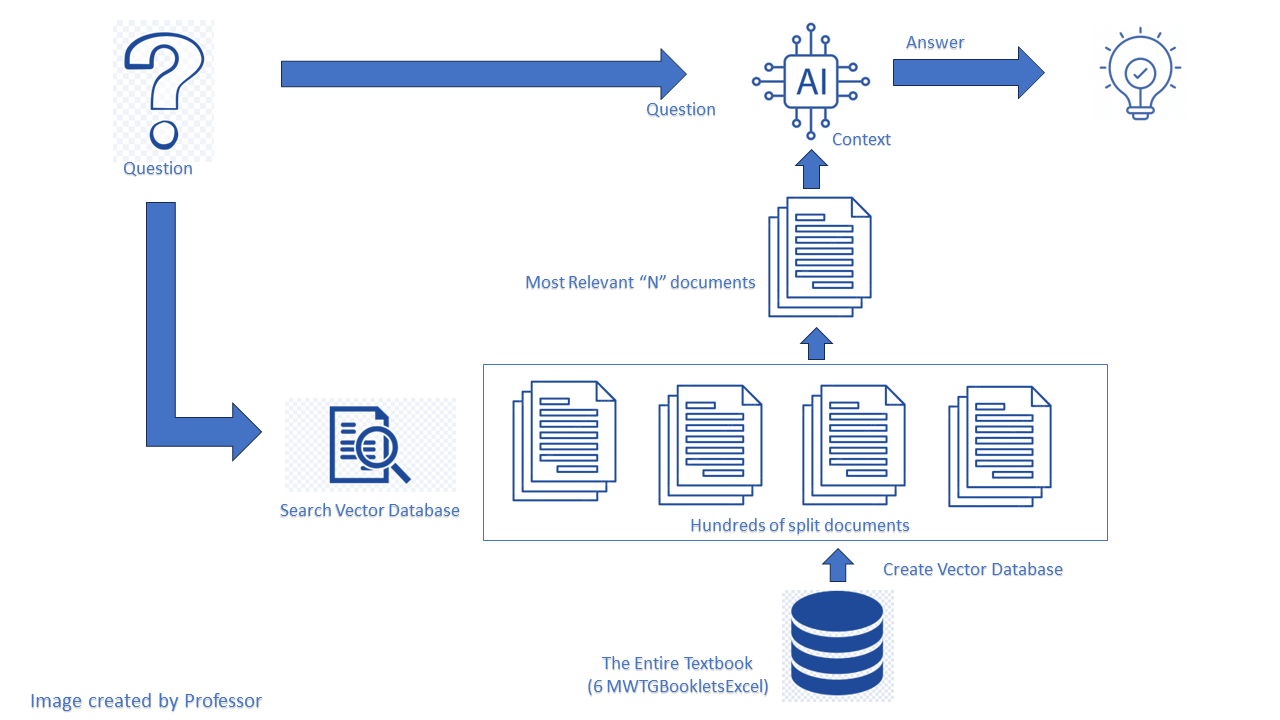

### **Step 0: Setup and Installation**

Let's prepare our Colab environment.


#### **1. Install Required Libraries**
We need libraries to process PDFs, handle embeddings, create a vector store, and interact with LangChain.

*   `pypdf`: To load and read PDF files.
*   `sentence-transformers`: To use the Hugging Face embedding model.
*   `faiss-cpu`: A powerful and efficient vector store from Meta AI.
*   `gdown`: To easily download our PDF files into Colab.

In [ ]:
# In a Colab notebook cell
!pip install langchain langchain-groq pypdf sentence-transformers faiss-cpu gdown langchain_community langchain-text-splitters langchain-classic -q

In [ ]:
# Groq Cloud API Key
import os
GROQ_API_KEY="gsk_....................."
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
print("✅ Groq API Key loaded.")

✅ Groq API Key loaded.


In [ ]:
# Create a directory for our documents
!mkdir documents

### **Part 1: Loading and Chunking Documents**

We can't feed entire PDF documents to the LLM at once. We need to break them down into smaller, manageable "chunks."

In [ ]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1. Load the documents from the 'documents' directory
loader = PyPDFDirectoryLoader("documents")
docs = loader.load()
print(f"Loaded {len(docs)} documents.")

# 2. Split the documents into smaller chunks
# This is crucial for the embedding model and for retrieving relevant context.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=750, chunk_overlap=50)
chunks = text_splitter.split_documents(docs)
print(f"Split documents into {len(chunks)} chunks.")

# Let's inspect a chunk to see what it looks like
print("\n--- Example Chunk ---")
print(chunks[20].page_content)

Loaded 17 documents.
Split documents into 42 chunks.

--- Example Chunk ---
As part of this release, we’re sharing the SAM 3 model weights, a new evaluation
benchmark dataset for open vocabulary segmentation, and a research paper that
details how we built SAM 3. We’re also partnering with the Roboflow annotation
platform so you can annotate data and fine-tune SAM 3 for your particular needs.
For SAM 3D, we’re sharing model checkpoints and inference code, and
introducing a novel benchmark for 3D reconstruction. This dataset features a
diverse array of images and objects, offering a level of realism and challenge that
surpasses existing 3D benchmarks. It represents a new standard for measuring
research progress in 3D and pushes the field toward a deeper understanding of
the physical world.


**Chunking is critical:** We do this because LLMs have a limited context window (the amount of text they can "see" at once) and for better search results. Smaller, focused chunks are more likely to match a specific user query. `chunk_overlap` helps maintain context between chunks.

### **Part 2: Embedding and Storing (Creating the Library's Index)**

Now we convert our text chunks into numbers (vectors) so we can perform a semantic search.

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

# 1. Initialize the Hugging Face Embedding Model
# BAAI/bge-small-en-v1.5 is a powerful and efficient open-source model.
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")
print("✅ Embedding model loaded.")

# 2. Create the Vector Store
# This single line of code will download the model, embed all our chunks,
# and store them in a FAISS vector store for fast retrieval.
print("Creating vector store... This may take a moment.")
vectorstore = FAISS.from_documents(chunks, embeddings)
print("✅ Vector store created successfully.")

/tmp/ipython-input-4080411164.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Embedding model loaded.
Creating vector store... This may take a moment.
✅ Vector store created successfully.


*   **Embeddings:** Explain the core idea. "Goodluck Jonathan" and "former Nigerian president" will have very similar vector representations, even though the words are different. This is how "semantic search" works.
*   **FAISS:** This is our in-memory "library index" or database. It's incredibly fast at finding the most similar vectors to a given query vector. `FAISS.from_documents` is a powerful helper that does all the heavy lifting for us.

### **Part 3: The RAG Chain - Retrieval and Generation**

Now we'll build the actual chain that connects all the pieces: `User Query -> Retrieve -> Augment -> Generate`.

In [ ]:
from langchain_groq import ChatGroq
from langchain_classic.chains.combine_documents import create_stuff_documents_chain
from langchain_classic.chains import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate

# 1. Initialize the Groq LLM for generation
llm = ChatGroq(model_name="meta-llama/llama-4-maverick-17b-128e-instruct")

# 2. Create the Retriever
# The retriever's job is to fetch the relevant chunks from our vector store.
retriever = vectorstore.as_retriever(search_kwargs={"k": 3}) # Retrieve top 3 most relevant chunks

# 3. Create the Prompt Template
# This is the most important part of RAG. We instruct the LLM to answer
# the user's question BASED ONLY on the provided context (our retrieved chunks).
prompt = ChatPromptTemplate.from_template("""
Answer the following question based only on the provided context.
Think step-by-step and provide a detailed answer. If you don't know the answer,
just say that you don't have enough information from the provided documents.
DO NOT use any of your own knowledge.

<context>
{context}
</context>

Question: {input}
""")

In [ ]:
# 4. Create the "Stuff" Documents Chain
# This chain takes the retrieved documents and "stuffs" them into the prompt.
document_chain = create_stuff_documents_chain(llm, prompt)

# 5. Create the Full Retrieval Chain
# This master chain orchestrates everything: it takes the user's query,
# uses the retriever to get the documents, and then passes them to the document_chain.
retrieval_chain = create_retrieval_chain(retriever, document_chain)

print("✅ RAG chain created successfully.")

✅ RAG chain created successfully.


### **Part 4: Ask Questions to Your Expert!**

Now for the fun part. Let's ask questions that can only be answered by our documents.

In [ ]:
# --- Test Case 1: From the Jonathan Interview PDF ---
question = "Why did former President Jonathan use an Ivorian jet to return to Nigeria?"
print(f"Question: {question}")
response = retrieval_chain.invoke({"input": question})
print("\n--- Answer ---")
print(response["answer"])

print("\n" + "="*50 + "\n")

Question: Why did former President Jonathan use an Ivorian jet to return to Nigeria?

--- Answer ---
According to the provided context, former President Goodluck Jonathan used an Ivorian jet to return to Nigeria because of the recent political unrest in Guinea-Bissau. He explained that President Bola Tinubu had prepared to dispatch a Nigerian jet, but Côte d'Ivoire secured an earlier landing permit, allowing Jonathan to board the Ivorian aircraft. In essence, the Ivorian jet was able to depart or land earlier than the planned Nigerian jet, prompting Jonathan to use it to return to Nigeria.




In [ ]:
# --- Test Case 2: From the Meta AI PDF ---
question = "What does Meta's SAM 3D model do?"
print(f"Question: {question}")
response = retrieval_chain.invoke({"input": question})
print("\n--- Answer ---")
print(response["answer"])

print("\n" + "="*50 + "\n")

Question: What does Meta's SAM 3D model do?

--- Answer ---
According to the provided context, Meta's SAM 3D model consists of two open-source models that enable the reconstruction of a 3D object from a single image. Specifically, SAM 3D Objects enables object and scene reconstruction, while SAM 3D Body enables human body and shape estimation. Both models deliver robust, state-of-the-art performance, with SAM 3D Objects significantly outperforming existing methods. The SAM 3D model has the potential to advance fields like robotics, science, and sports medicine, and has creative use cases such as generating assets for games and AR/VR applications. 

In summary, Meta's SAM 3D model reconstructs 3D objects from a single image, enabling applications such as object and scene reconstruction, and human body and shape estimation.




In [ ]:
# --- Test Case 3: From the Stranger Things Review PDF ---
question = "According to the review, what is the main problem with the cast in Stranger Things season five?"
print(f"Question: {question}")
response = retrieval_chain.invoke({"input": question})
print("\n--- Answer ---")
print(response["answer"])

print("\n" + "="*50 + "\n")

Question: According to the review, what is the main problem with the cast in Stranger Things season five?

--- Answer ---
According to the review, the main problem with the cast in Stranger Things season five is that they are all visibly in their 20s, which is a problem because the show's charm lies in watching kids outrun monsters and having adventures together, implying that the cast's age no longer fits the show's original dynamic.




In [ ]:
# --- Test Case 4: The Hallucination Test ---
# Ask a question that is NOT in our documents.
question = "What is the capital of France?"
print(f"Question: {question}")
response = retrieval_chain.invoke({"input": question})
print("\n--- Answer ---")
print(response["answer"])

Question: What is the capital of France?

--- Answer ---
I don't have enough information from the provided context to determine the capital of France. The given text does not contain any relevant information about France or its capital.


This is the payoff.
*   For the first three questions, the AI will answer correctly and in detail, because the retriever found the right context.
*   For the fourth question, the AI should (if the prompt works well) respond by saying it doesn't have that information in the provided documents. This is a **successful** result! It proves our RAG system is working and not just using its own general knowledge.


### **Conclusion & Next Steps**

Congratulations! You have just built a complete, end-to-end RAG system. You have given an AI a custom brain, allowing it to become a factual expert on any topic you choose.

**You have learned how to:**
*   Load and process PDF documents.
*   Use open-source embedding models from Hugging Face.
*   Create and search a vector database with FAISS.
*   Build a complete Retrieval-Augmented Generation chain.
*   Prevent hallucinations by grounding your LLM in specific context.

**Your Next Challenge:** How would you integrate this `retrieval_chain` into your Streamlit agent app? You could create a new custom tool called `query_document_expert` that uses this chain! The possibilities are endless.